In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import glob
import getpass
import importlib
import functions
import spectrogram_plotting_functions
import scipy.signal
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

## 02 Loading the folder that contains our data

In [ ]:

user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

In [4]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#files=['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk1_nocontext.mat']
event_data_df=[]
shuffled_event_data_df=[]
events_codes_all = {}
before_data_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
scrambled_baseline_power_df=pd.DataFrame(columns=['rat_id','task','channel_id','before_data_power','before_data_spec'])
averaged_data=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
averaged_data_welch=pd.DataFrame(columns=['rat_id','task','channel_id','average_power_spectrum'])
random_baseline_data=[]
for file in files:
    #if 'dk6' in file:
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, rat_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)

        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)

        first_event = events_times[0]
        for channeli in channels:
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)

                normalized_data, time, data_before = functions.data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                
                # This makes a dataframe for calculating baseline power 
                bd_freq, bd_power = scipy.signal.welch(data_before,fs=2000.0, nperseg=512)
                #before_data_power=functions.calculate_power_1D(data_before)
                
                #before_data_power = np.sum(bd_power) * delta_f
                
                def band_powers(data, freqs):
                    delta_f = freqs[1] - freqs[0]

                    theta = np.where((freqs >= 4) & (freqs <= 12))
                    beta = np.where((freqs >= 12) & (freqs <= 30))
                    gamma = np.where((freqs >= 30) & (freqs <= 100))
                    total_power = np.sum(data)*delta_f
                    theta_power = np.sum(data[theta])*delta_f
                    beta_power = np.sum(data[beta])*delta_f
                    gamma_power = np.sum(data[gamma])*delta_f
                    return total_power, theta_power, beta_power, gamma_power
                
                before_data_power, baseline_theta_power, baseline_beta_power, baseline_gamma_power = band_powers(bd_power, bd_freq)
                before_data_row=pd.DataFrame({'rat_id':[rat_id],'task':[task],'channel_id':[channel_id],'before_data_power':[before_data_power],'before_data_spec':[bd_power],'beta_power':[baseline_beta_power],'theta_power':[baseline_theta_power],'gamma_power':[baseline_gamma_power]})
                before_data_power_df=pd.concat([before_data_power_df,before_data_row],ignore_index=True)
                
                scrambled_baseline_data=np.copy(data_before)
                #This makes a dataframe for calculating scrambled baseline power
                np.random.shuffle(scrambled_baseline_data)
                scrambled_baseline_freq, scrambled_baseline_power = scipy.signal.welch(scrambled_baseline_data,fs=2000.0, nperseg=512)
                scrambled_baseline_total_power, scrambled_baseline_theta_power, scrambled_baseline_beta_power, scrambled_baseline_gamma_power = band_powers(scrambled_baseline_power, scrambled_baseline_freq)
                scrambled_baseline_row = pd.DataFrame({'rat_id':[rat_id],'task':[task],'channel_id':[channel_id],
                                                       'before_data_power':[scrambled_baseline_total_power],'before_data_spec':[scrambled_baseline_power],
                                                       'beta_power':[scrambled_baseline_beta_power],'theta_power':[scrambled_baseline_theta_power],
                                                       'gamma_power':[scrambled_baseline_gamma_power]})
                scrambled_baseline_power_df=pd.concat([scrambled_baseline_power_df,scrambled_baseline_row],ignore_index=True)
                
                
                ##Calculate the power spectrum around events for each trial

                total = normalized_data
                compiled_data = []
                power_spectra = []
                
                compiled_data_welch = []
                power_spectra_welch = []

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    event_time=np.linspace(0,2,2*sampling_rate)
                    event_row=[]
                    shuffled_event_row=[]

                    event_row.extend([rat_id, task, channeli,before_data_power, baseline_beta_power, baseline_theta_power, baseline_gamma_power, i])
                    shuffled_event_row.extend([rat_id, task, channeli,scrambled_baseline_total_power, scrambled_baseline_beta_power, scrambled_baseline_theta_power, scrambled_baseline_gamma_power, i])
                    
                    for event_data in event_data_list:
                        faxis, Sxx_event = scipy.signal.welch(event_data,sampling_rate,nperseg=1024)
                        event_row.append(np.abs(Sxx_event))
                        total_power, theta_power, beta_power, gamma_power = band_powers(Sxx_event, faxis)
                        event_row.extend([total_power,beta_power, theta_power, gamma_power])
                        
                        #shuffled data
                        shuffled_data=np.copy(event_data)
                        np.random.shuffle(shuffled_data)
                        faxis_shuffled, Sxx_event_shuffled = scipy.signal.welch(shuffled_data,sampling_rate,nperseg=1024)
                        total_power_shuffled, theta_power_shuffled, beta_power_shuffled, gamma_power_shuffled = band_powers(Sxx_event_shuffled, faxis_shuffled)
                        shuffled_event_row.append(np.abs(Sxx_event_shuffled))
                        shuffled_event_row.extend([total_power_shuffled,beta_power_shuffled, theta_power_shuffled, gamma_power_shuffled])
                        

                    event_data_df.append(event_row)
                    shuffled_event_data_df.append(shuffled_event_row)


event_data_compiled_df = pd.DataFrame(event_data_df, columns=['rat_id','task','channel_id','baseline total','baseline beta','baseline theta','baseline gamma','trial','door before','door before total','door before beta','door before theta','door before gamma', 'door after','door after total','door after beta','door after theta','door after gamma','dig before','dig before total','dig before beta','dig before theta','dig before gamma','dig after','dig after total','dig after beta','dig after theta','dig after gamma'])
shuffled_event_data_compiled_df=pd.DataFrame(shuffled_event_data_df, columns=['rat_id','task','channel_id','baseline total','baseline beta','baseline theta','baseline gamma','trial','door before','door before total','door before beta','door before theta','door before gamma', 'door after','door after total','door after beta','door after theta','door after gamma','dig before','dig before total','dig before beta','dig before theta','dig before gamma','dig after','dig after total','dig after beta','dig after theta','dig after gamma'])
#shuffled_event_data_compiled_df = pd.DataFrame(shuffled_event_data_df, columns=['rat_id','task','channel_id','baseline total','baseline beta','baseline theta','baseline gamma','trial','door before','door before beta','door before theta','door before gamma', 'door after','door after beta','door after theta','door after gamma','dig before','dig before beta','dig before theta','dig before gamma','dig after','dig after beta','dig after theta','dig after gamma'])

In [ ]:
print(data_before)
scrambled_baseline_data=np.array(np.random.shuffle(data_before))
print(scrambled_baseline_data)

In [ ]:
print(len(event_data_df[0]))

Baseline Total power for individual tasks

In [ ]:
import seaborn as sns
brain_areas = ['AON', 'vHp']
tasks = np.unique(scrambled_baseline_power_df['task'])

fig,axs=plt.subplots(nrows=1, ncols=3, figsize=(20,10))
axs=axs.flatten()
for i,task in enumerate(tasks):
    task_dict={}
    task_df=scrambled_baseline_power_df[scrambled_baseline_power_df['task']==task]
    task_df['channel_id'] = task_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    task_df['channel_id'] = task_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
    rat_ids = np.unique(task_df['rat_id'])

    for rat in rat_ids:
        task_dict[rat]=np.array(task_df[task_df['rat_id']==rat]['before_data_power'])
    
    # Convert task_dict to a DataFrame
    #task_df_csv = pd.DataFrame.from_dict(task_dict, orient='index').transpose()
    
    # Save the DataFrame as a CSV file
    #task_df_csv.to_csv(os.path.join(savepath,f'task_{task}_baseline_power.csv'), index=False)
    
    #Plotting the thing
    ax=axs[i]
    sns.boxplot(x=task_df['rat_id'], y=task_df['before_data_power'],showfliers=False, hue=task_df['channel_id'],ax=ax)
    sns.stripplot(x=task_df['rat_id'], y=task_df['before_data_power'], hue=task_df['channel_id'],ax=ax, jitter=True, dodge=True,edgecolor='black',linewidth=1)

    ax.set_title(f'{task}')
#fig.savefig(os.path.join(savepath,'baselinepower_indtask.png'),format='png',dpi=300, bbox_inches='tight')

baseline total power for individual rat

In [ ]:
import seaborn as sns
brain_areas = ['AON', 'vHp']
rats = np.unique(scrambled_baseline_power_df['rat_id'])

fig,axs=plt.subplots(nrows=1, ncols=len(rats), figsize=(20,10))
axs=axs.flatten()
for i,rat in enumerate(rats):
    rat_dict={}
    rat_df=scrambled_baseline_power_df[scrambled_baseline_power_df['rat_id']==rat]
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
    tasks = np.unique(rat_df['task'])

    for task in tasks:
        rat_dict[task]=np.array(rat_df[rat_df['task']==task]['before_data_spec'])
    
    # Convert task_dict to a DataFrame
    #rat_df_csv = pd.DataFrame.from_dict(rat_dict, orient='index').transpose()
    
    # Save the DataFrame as a CSV file
    #rat_df_csv.to_csv(os.path.join(savepath,f'task_{rat}_baseline_power.csv'), index=False)
    
    #Plotting the thing
    ax=axs[i]
    sns.boxplot(x=rat_df['task'], y=rat_df['before_data_power'],showfliers=False, hue=rat_df['channel_id'],ax=ax)
    sns.stripplot(x=rat_df['task'], y=rat_df['before_data_power'], hue=rat_df['channel_id'],ax=ax, jitter=True, dodge=True,edgecolor='black',linewidth=1)

    ax.set_title(f'{rat}')
#fig.savefig(os.path.join(savepath,'baselinepower_indrat.png'),format='png',dpi=300, bbox_inches='tight')

Baseline power Spectra and Band power plotting

In [ ]:
import seaborn as sns

def power_spec_and_bands_plot(power_df):
    brain_areas = ['AON', 'vHp']
    rats = np.unique(power_df['rat_id'])
    tasks=['BWnocontext','BWcontext']

    palette = sns.color_palette("husl", 4)  # Using the 'husl' palette with 4 colors
    fig,axs=plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharey=True)
    axs=axs.flatten()
    rat_power_df=[]
    for i,rat in enumerate(rats):
        rat_dict={}
        rat_df=power_df[power_df['rat_id']==rat]
        rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
        rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )
        #tasks = np.unique(rat_df['task'])
        for area in brain_areas:
            for task in tasks:
                rat_df_task_spec=rat_df[(rat_df['task']==task) & (rat_df['channel_id']==area)]['before_data_spec']
                rat_beta_power=rat_df[(rat_df['task']==task) & (rat_df['channel_id']==area)]['beta_power']
                rat_theta_power=rat_df[(rat_df['task']==task) & (rat_df['channel_id']==area)]['theta_power']
                rat_gamma_power=rat_df[(rat_df['task']==task) & (rat_df['channel_id']==area)]['gamma_power']
                rat_total_power=rat_df[(rat_df['task']==task) & (rat_df['channel_id']==area)]['before_data_power']
                rat_power_row=[rat,task,area,np.nanmean(rat_total_power),np.nanmean(rat_beta_power),np.nanmean(rat_theta_power),np.nanmean(rat_gamma_power)]
                if not rat_df_task_spec.empty:
                    
                    rat_baseline_power=np.mean(np.abs(rat_df_task_spec))
                    rat_baseline_sem=scipy.stats.sem(np.abs(rat_df_task_spec))
                    rat_dict[f'{area}_{task}_mean']=rat_baseline_power
                    rat_dict[f'{area}_{task}_sem']=rat_baseline_sem

                    faxis=np.linspace(0,1000,len(rat_baseline_power))

                    ax=axs[i]
                    color = palette[tasks.index(task)]  # Get color from palette based on task
                    if area=='vHp':
                        ax.plot(faxis, rat_baseline_power, label=f'{area}_{task}', linestyle='--',color=color)
                        ax.fill_between(faxis,rat_baseline_power-rat_baseline_sem,rat_baseline_power+rat_baseline_sem,color=color, alpha=0.2)
                    else:
                        ax.plot(faxis, rat_baseline_power, label=f'{area}_{task}',color=color)
                        ax.fill_between(faxis,rat_baseline_power-rat_baseline_sem,rat_baseline_power+rat_baseline_sem, alpha=0.2,color=color)
                rat_power_df.append(rat_power_row)
        ax.set_xlim([0,100])
        ax.legend()    
        ax.set_title(f'{rat}')
        # rat_df_csv = pd.DataFrame.from_dict(rat_dict, orient='index').transpose()
        # rat_df_csv.to_csv(os.path.join(savepath,f'rat_{rat}_baseline_power.csv'), index=False)
    rat_power_df = pd.DataFrame(rat_power_df, columns=['rat_id','task','area','total power','baseline beta','baseline theta','baseline gamma'])

    #baseline_band_power_df=pd.concat(baseline_band_power, ignore_index=True)
    plt.show()
    # #fig.savefig(os.path.join(savepath,'baselinepower_spectrum.png'),format='png',dpi=300, bbox_inches='tight')

    "Baseline power for each band"
    # Create subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
    axs = axs.flatten()

    # Define brain areas and bands
    brain_areas = ['AON', 'vHp']
    bands = ['total power','baseline beta', 'baseline theta', 'baseline gamma']

    # Iterate over brain areas
    for i, area in enumerate(brain_areas):
        area_df = rat_power_df[rat_power_df['area'].str.contains(area)]
        ax = axs[i]
        
        # Melt the DataFrame to long format for Seaborn
        melted_df = area_df.melt(id_vars=['rat_id', 'task'], value_vars=bands, var_name='Band', value_name='Power')
        
        # Create the boxplot
        sns.boxplot(x='Band', y='Power', hue='task', data=melted_df, ax=ax, showfliers=False)
        
        # Add individual data points
        sns.stripplot(x='Band', y='Power', hue='task', data=melted_df, dodge=True, ax=ax, linewidth=1, alpha=0.7)
        
        # Set the title
        ax.set_title(f'{area} Baseline Band Powers')
        
        # Remove the duplicate legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[0:len(bands)], labels[0:len(bands)])
    #fig.savefig(os.path.join(savepath, 'baseline_band_power.png'), format='png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()

power_spec_and_bands_plot(before_data_power_df)

Normalization by baseline power

In [ ]:
import itertools
import scipy.stats as stats

rats=np.unique(event_data_compiled_df['rat_id'])
tasks=['BWnocontext','BWcontext']
brain_areas=['AON','vHp']
area='AON'
rat='dk1'
task='BWnocontext'
event_data_df=event_data_compiled_df[(event_data_compiled_df['rat_id']==rat) & (event_data_compiled_df['task']==task)]
baseline_data_df=before_data_power_df[(before_data_power_df['rat_id']==rat) & (before_data_power_df['task']==task)]

pre_norm_rat_dict={}
post_norm_rat_dict={}

for rati in rats:
    rat_event_data=event_data_compiled_df[(event_data_compiled_df['rat_id']==rati)&(event_data_compiled_df['task']==task)&(event_data_compiled_df['channel_id'].str.contains(area))]
    pre_normalized_door_after_beta=rat_event_data['door after beta']
    pre_norm_rat_dict[rati]=pre_normalized_door_after_beta
    post_normalized_door_after_beta=rat_event_data['door after beta']/rat_event_data['baseline beta']
    post_norm_rat_dict[rati]=post_normalized_door_after_beta

# Convert dictionary values to lists for plotting
pre_norm_rat_values = [v.dropna().values for v in pre_norm_rat_dict.values()]
post_norm_rat_values = [v.dropna().values for v in post_norm_rat_dict.values()]
# Perform pairwise comparisons using Mann-Whitney U test

# Perform pairwise comparisons using Mann-Whitney U test
pairwise_results = {}
alpha = 0.05  # Significance level

for (rat1, values1), (rat2, values2) in itertools.combinations(post_norm_rat_dict.items(), 2):
    u_stat, p_value = stats.mannwhitneyu(values1.dropna().values, values2.dropna().values, alternative='two-sided')
    pairwise_results[(rat1, rat2)] = (u_stat, p_value)

# Print the results
for (rat1, rat2), (u_stat, p_value) in pairwise_results.items():
    significance = "significant" if p_value < alpha else "not significant"
    print(f"Comparison between {rat1} and {rat2}:")
    print(f"  Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_value} ({significance})")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axs = axs.flatten()

# Plot pre-normalized data
axs[0].boxplot(pre_norm_rat_values, showfliers=False)
axs[0].set_title('Pre-normalized Door_after AON beta power')
axs[0].set_ylabel('Power')
axs[0].set_xticklabels(rats)

# Plot post-normalized data
axs[1].boxplot(post_norm_rat_values, showfliers=False)
axs[1].set_title('Post-normalized Door_after AON beta power')
axs[1].set_ylabel('Normalized Power')
axs[1].set_xticklabels(rats)

plt.show()
    

averaged power spectrum, complete trial, ind rat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}
averaged_data=averaged_data_welch

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(averaged_data['rat_id'])
tasks = np.unique(averaged_data['task'])

for rat in rat_ids:
    rat_data = averaged_data[averaged_data['rat_id'] == rat]

    fig, ax = plt.subplots(figsize=(20, 10))

    for i, task in enumerate(tasks):
        task_data = rat_data[rat_data['task'] == task]
        task_data = task_data.reset_index(drop=True)
        task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
        task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
        task_data_vhp = task_data_vhp.reset_index(drop=True)
        task_data_aon = task_data_aon.reset_index(drop=True)

        color_aon = color_scheme['AON'][i % len(color_scheme['AON'])]
        color_vhp = color_scheme['vHp'][i % len(color_scheme['vHp'])]

        if not task_data_vhp.empty:
            # Ensure all power spectra have the same length
            min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
            task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
            task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
            
            faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))

            ax.plot(faxis,task_data_vhp_mean, label=f'vHp_{task}', color=color_vhp, linestyle='--')

        if not task_data_aon.empty:
            # Ensure all power spectra have the same length
            min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
            task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
            task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
            faxis=np.linspace(0,1000,num=len(task_data_aon_mean))
            ax.plot(faxis, task_data_aon_mean, label=f'AON_{task}', color=color_aon)

    ax.set_xlim(0, 100)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.set_title(f'Average Power Spectrum by Task and Brain Area for rat {rat}')
    ax.legend()
    #fig.savefig(os.path.join(savepath,f'average_power_spectrum_complete_trial_{rat}.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
!pip install xlsxwriter

## Now we will make averaged power spectrum around events for each rat

In [ ]:



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_compiled_df=shuffled_event_data_compiled_df

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door before', 'door after', 'dig before', 'dig after']
tasks=['BWnocontext','BWcontext']

for rat in rat_ids:
    writer = pd.ExcelWriter(os.path.join(savepath,f'{rat} average power spectrum around events.xlsx'), engine='xlsxwriter')

    rat_data = data_compiled_df[data_compiled_df['rat_id'] == rat]
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    rat_df['channel_id'] = rat_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )

    # # Calculate door norm by individual
    # rat_data['door norm by ind'] = rat_data['door after'] - rat_data['door before']
    
    # # Calculate the mean of the entire 'door before' column
    # mean_door_before = rat_data['door before'].mean()
    # rat_data['door norm by mean'] = rat_data['door after'] - mean_door_before
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey=True, sharex=True)
    fig.suptitle(f'{rat} event power spectrum')
    axs = axs.flatten()
    
    for event_num, event in enumerate(events_list):
        average_event_power_spectrum_df=pd.DataFrame()

        events_data = rat_data[['rat_id', 'channel_id', 'task', 'trial', event]]
        ax = axs[event_num]
        ax.set_title(f'{event}')
        
        #test case
        for i, task in enumerate(tasks):
            
            task_data = events_data[events_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)

            if not task_data_vhp.empty:
                task_data_vhp_mean = np.mean(task_data_vhp[event], axis=0)
                task_data_vhp_sem=scipy.stats.sem(task_data_vhp[event], axis=0
)
                faxis = np.linspace(0, 1000, num=len(task_data_vhp_mean))

                ax.plot(faxis, task_data_vhp_mean, label=f'vHp_{task}', linestyle='--')
                ax.fill_between(faxis, task_data_vhp_mean-task_data_vhp_sem,task_data_vhp_mean+task_data_vhp_sem, alpha=0.2, label=f'vHp_{task}_sem')
            if not task_data_aon.empty:
                task_data_aon_mean = np.mean(task_data_aon[event], axis=0)
                task_data_aon_sem=scipy.stats.sem(task_data_aon[event], axis=0)

                faxis = np.linspace(0, 1000, num=len(task_data_aon_mean))

                ax.plot(faxis, task_data_aon_mean, label=f'AON_{task}')

                ax.fill_between(faxis, task_data_aon_mean-task_data_aon_sem,task_data_aon_mean+task_data_aon_sem, alpha=0.2, label=f'AON_{task}_sem')
            
            average_event_power_spectrum_df[f'vHp_{task}']=task_data_vhp_mean
            average_event_power_spectrum_df[f'AON_{task}']=task_data_aon_mean
        average_event_power_spectrum_df.insert(0,'frequency',faxis)
        average_event_power_spectrum_df.to_excel(writer, sheet_name=event)
        ax.set_xlim(0, 100)
        ax.legend()
    writer.close()
    #fig.savefig(os.path.join(savepath, f'average_power_spectrum_around_events_{rat}.png'),dpi=300, bbox_inches='tight')
    plt.show()

Making a boxplot for power in each band, AON Pre-door, normalized by baseline power in that band

C:\Users\sinha\AppData\Local\Temp\ipykernel_15844\2386340240.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aon_data['pre door total normalized']=aon_data['door before total']/aon_data['baseline total']
C:\Users\sinha\AppData\Local\Temp\ipykernel_15844\2386340240.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aon_data['pre door beta normalized']=aon_data['door before beta']/aon_data['baseline beta']
C:\Users\sinha\AppData\Local\Temp\ipykernel_15844\2386340240.py:23: SettingWithCopyWarning: 
A va

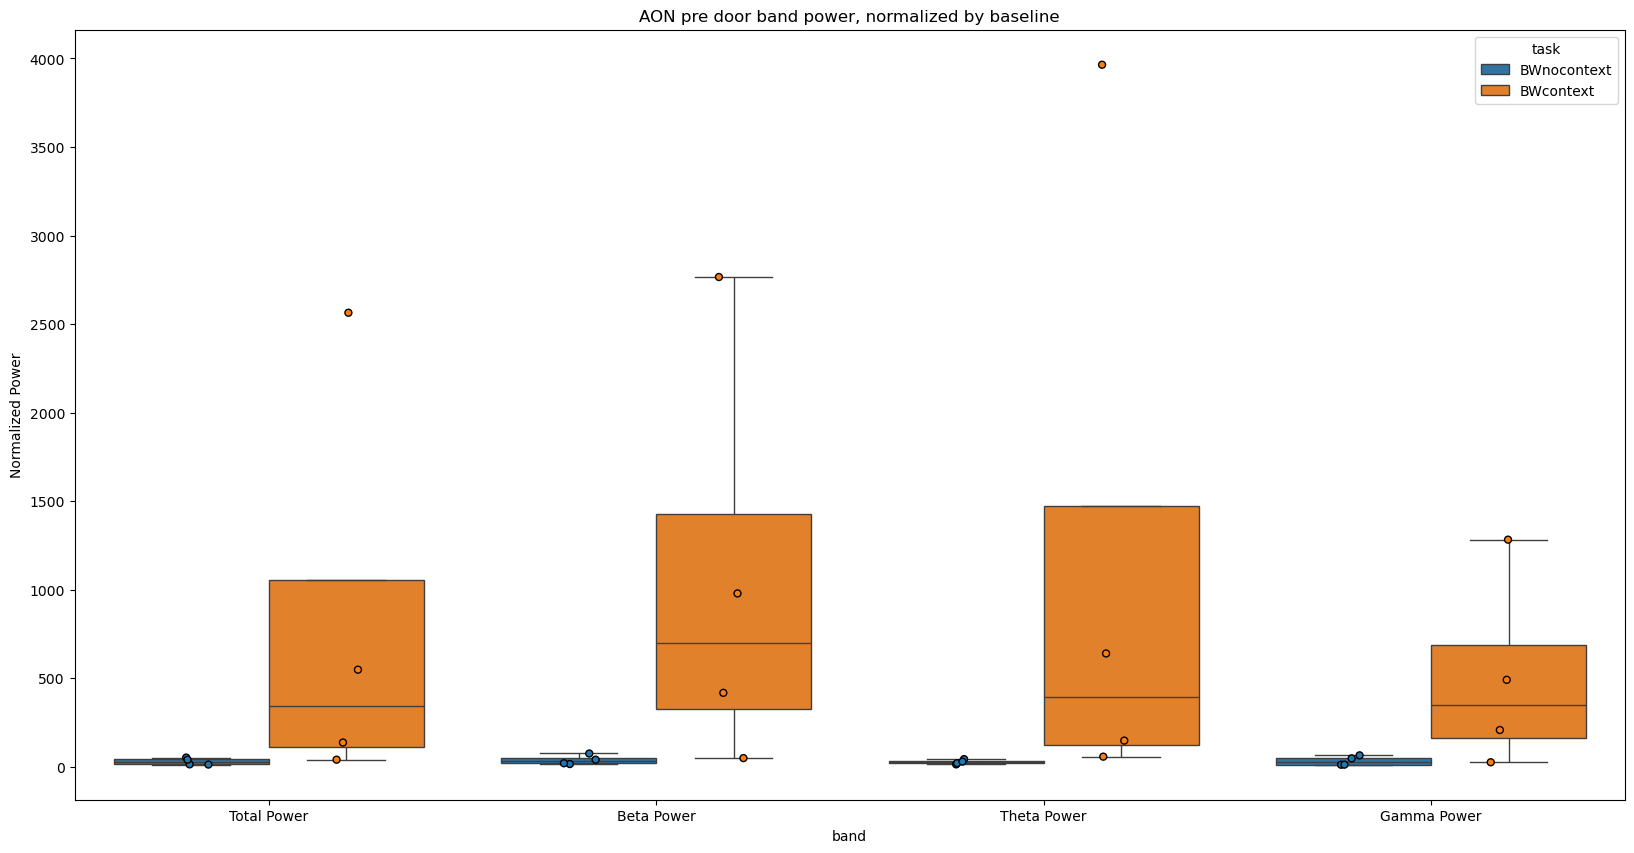

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_compiled_df=event_data_compiled_df

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door before', 'door after', 'dig before', 'dig after']
tasks=['BWnocontext','BWcontext']

data_compiled_df['channel_id'] = data_compiled_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
data_compiled_df['channel_id'] = data_compiled_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )


aon_data=data_compiled_df[data_compiled_df['channel_id']=='AON']
vhp_data=data_compiled_df[data_compiled_df['channel_id']=='vHp']

aon_data['pre door total normalized']=aon_data['door before total']/aon_data['baseline total']
aon_data['pre door beta normalized']=aon_data['door before beta']/aon_data['baseline beta']
aon_data['pre door theta normalized']=aon_data['door before theta']/aon_data['baseline theta']
aon_data['pre door gamma normalized']=aon_data['door before gamma']/aon_data['baseline gamma']

bands=['pre door total normalized','pre door beta normalized','pre door theta normalized','pre door gamma normalized']
mean_band_power=[]
for rat_num, rat_id in enumerate(rat_ids):
    rat_data=aon_data[aon_data['rat_id']==rat_id]
    #rat_row.append(rat_id)
    for task in tasks:
        task_data=rat_data[rat_data['task']==task]
        rat_row=[]

        rat_row.append(rat_id)
        rat_row.append(task)
        
        for band in bands:
            rat_row.append(np.mean(task_data[band]))
        mean_band_power.append(rat_row)

#Plotting the data
mean_band_power_df=pd.DataFrame(mean_band_power,columns=['rat_id','task','pre door total normalized','pre door beta normalized','pre door theta normalized','pre door gamma normalized'])
mean_band_power_melted=pd.melt(mean_band_power_df,id_vars=['rat_id','task'],value_vars=['pre door total normalized','pre door beta normalized','pre door theta normalized','pre door gamma normalized'],var_name='band',value_name='power')
fig,axs=plt.subplots(nrows=1, ncols=1, figsize=(20,10))
axs=sns.boxplot(x='band',y='power',hue='task',data=mean_band_power_melted,showfliers=False)
axs=sns.stripplot(x='band',y='power',hue='task',data=mean_band_power_melted,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False)
axs.set_xticklabels(['Total Power', 'Beta Power', 'Theta Power', 'Gamma Power'])
axs.set_title('AON pre door band power, normalized by baseline')
axs.set_ylabel('Normalized Power')
plt.show()


Making a boxplot AON band power of pre door, post door, and pre dig - normalized by basline

  rat_id         task        event              band       power
0    dk1  BWnocontext  door_before  total normalized   52.469415
1    dk1    BWcontext  door_before  total normalized  548.631392
2    dk3  BWnocontext  door_before  total normalized   12.873060
3    dk3    BWcontext  door_before  total normalized   40.469181
4    dk5  BWnocontext  door_before  total normalized   14.017543


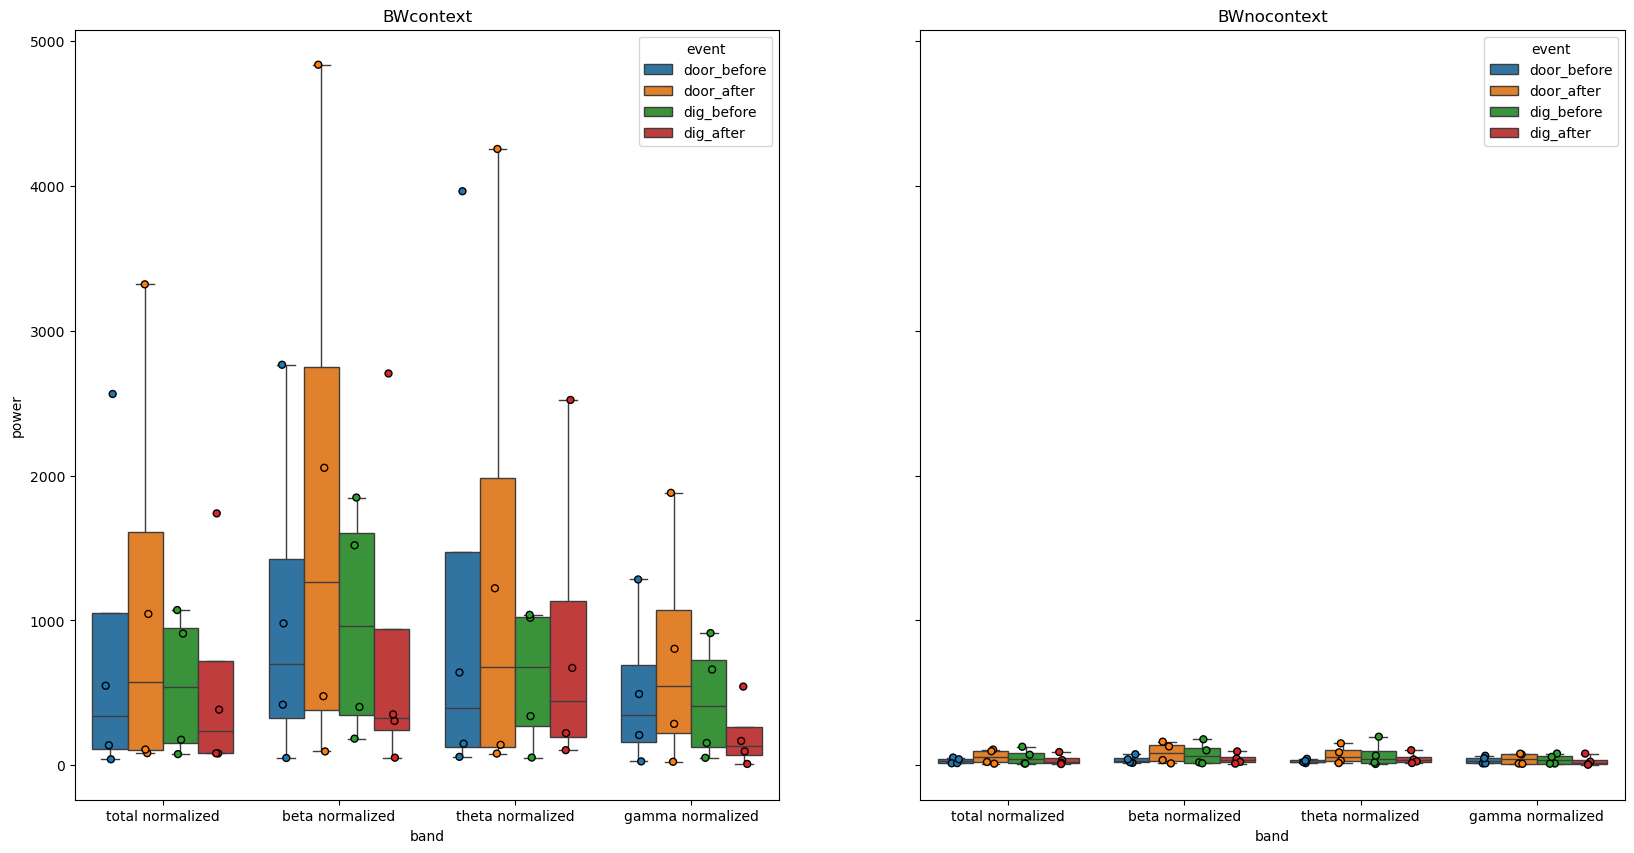

C:\Users\sinha\AppData\Local\Temp\ipykernel_15844\2870210972.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['Total Power', 'Beta Power', 'Theta Power', 'Gamma Power'])


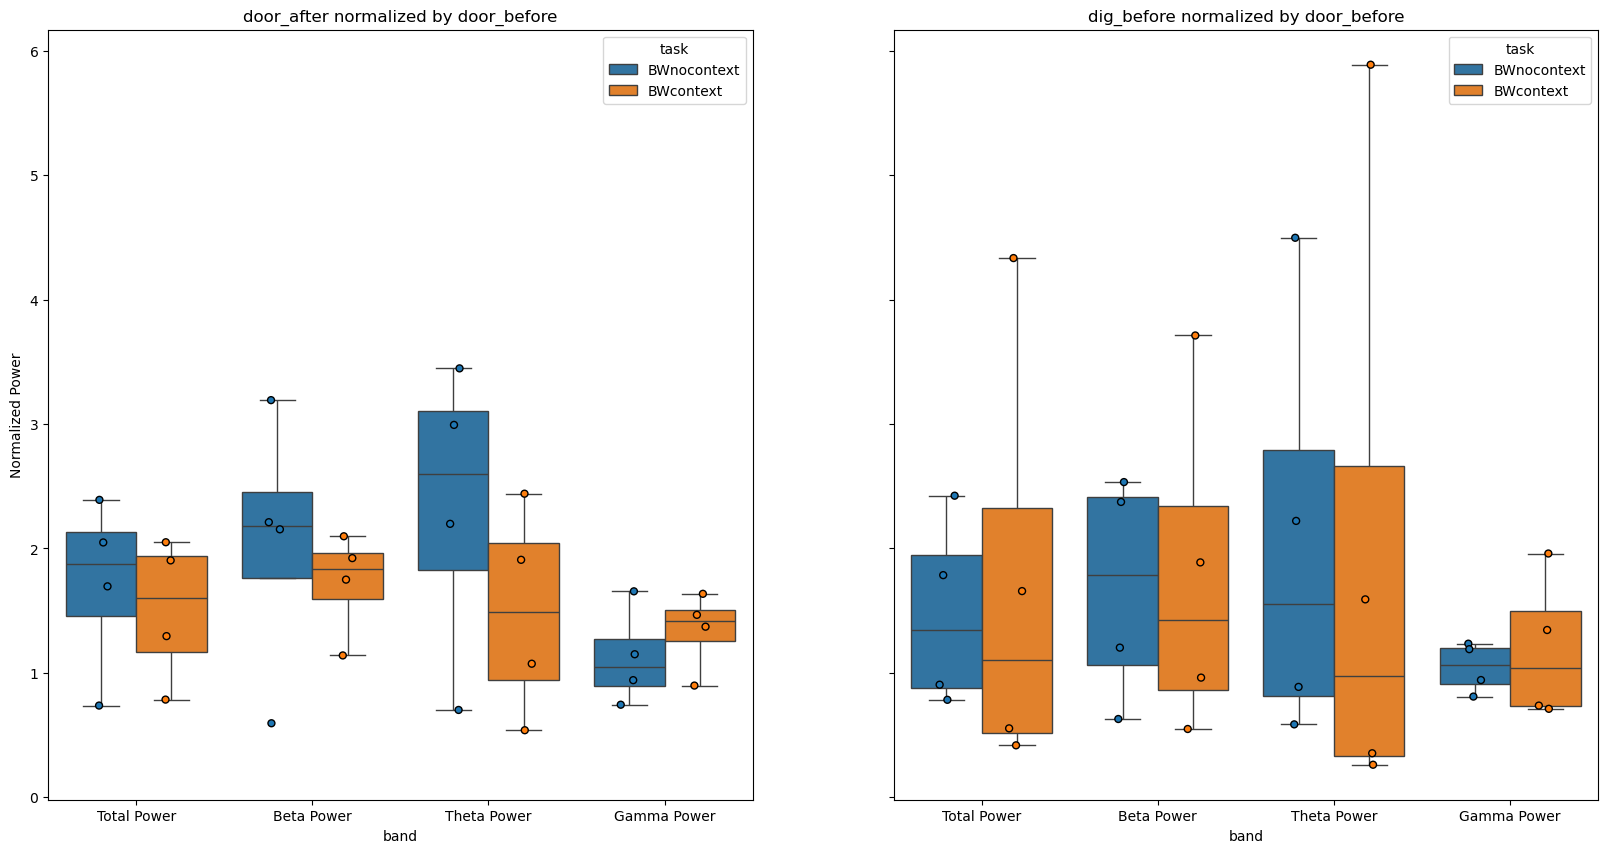

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_compiled_df=event_data_compiled_df

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door before', 'door after', 'dig before', 'dig after']
tasks=['BWnocontext','BWcontext']

data_compiled_df['channel_id'] = data_compiled_df['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
data_compiled_df['channel_id'] = data_compiled_df['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )

aon_data=data_compiled_df[data_compiled_df['channel_id']=='AON']
vhp_data=data_compiled_df[data_compiled_df['channel_id']=='vHp']

bands=['total', 'beta', 'theta', 'gamma']

# aon_data['pre door total normalized']=aon_data['door before total']/aon_data['baseline total']
# aon_data['pre door beta normalized']=aon_data['door before beta']/aon_data['baseline beta']
# aon_data['pre door theta normalized']=aon_data['door before theta']/aon_data['baseline theta']
# aon_data['pre door gamma normalized']=aon_data['door before gamma']/aon_data['baseline gamma']

# bands=['pre door total normalized','pre door beta normalized','pre door theta normalized','pre door gamma normalized']
mean_band_power=[]
for rat_num, rat_id in enumerate(rat_ids):
    rat_data=aon_data[aon_data['rat_id']==rat_id]
    #rat_row.append(rat_id)
    for task in tasks:
        task_data=rat_data[rat_data['task']==task]
        rat_row=[]

        rat_row.append(rat_id)
        rat_row.append(task)
        for event in events_list:
            for band in bands:
                
                column_name=f'{event} {band}'
                baseline_name=f'baseline {band}'
                mean_norm_power=np.mean(task_data[column_name]/task_data[baseline_name])
                rat_row.append(mean_norm_power)

        mean_band_power.append(rat_row)

# Original DataFrame
mean_band_power_df = pd.DataFrame(mean_band_power, columns=[
    'rat_id', 'task', 
    'door_before total normalized', 'door_before beta normalized', 'door_before theta normalized', 'door_before gamma normalized',
    'door_after total normalized', 'door_after beta normalized', 'door_after theta normalized', 'door_after gamma normalized',
    'dig_before total normalized', 'dig_before beta normalized', 'dig_before theta normalized', 'dig_before gamma normalized',
    'dig_after total normalized', 'dig_after beta normalized', 'dig_after theta normalized', 'dig_after gamma normalized'
])

# Reshape the DataFrame to have separate columns for event and band
mean_band_power_df_melted = mean_band_power_df.melt(id_vars=['rat_id', 'task'], var_name='event_band', value_name='power')

# Split the 'event_band' column into 'event' and 'band'
mean_band_power_df_melted[['event', 'band']] = mean_band_power_df_melted['event_band'].str.split(' ', n=1, expand=True)

# Drop the 'event_band' column
mean_band_power_df_melted = mean_band_power_df_melted.drop(columns=['event_band'])

# Reorder the columns
mean_band_power_df_melted = mean_band_power_df_melted[['rat_id', 'task', 'event', 'band', 'power']]
BWcontext_data = mean_band_power_df_melted[mean_band_power_df_melted['task'] == 'BWcontext']
BWnocontext_data = mean_band_power_df_melted[mean_band_power_df_melted['task'] == 'BWnocontext']
print(mean_band_power_df_melted.head())
#mean_band_power_melted_trunc=mean_band_power_melted[mean_band_power_melted['event band'].str.contains('beta') | mean_band_power_melted['event band'].str.contains('theta') | mean_band_power_melted['event band'].str.contains('gamma')]
# #Plotting the data
fig,axs=plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharex=True, sharey=True)
axs=axs.flatten()
sns.boxplot(x='band',y='power',hue='event',data=BWcontext_data,showfliers=False,ax=axs[0])
sns.stripplot(x='band',y='power',hue='event',data=BWcontext_data,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False,ax=axs[0])
event
axs[0].set_title('BWcontext')

sns.boxplot(x='band',y='power',hue='event',data=BWnocontext_data,showfliers=False,ax=axs[1])
sns.stripplot(x='band',y='power',hue='event',data=BWnocontext_data,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=axs[1])
axs[1].set_title('BWnocontext')

# axs[0].set_xticklabels(['Total Power', 'Beta Power', 'Theta Power', 'Gamma Power'])
# axs[0].set_ylabel('Normalized Power')
plt.show()



""""Now I will normalize the post door and pre dig events by the pre door event power"""

new_events=['door_after','dig_before']
mean_band_power_events=mean_band_power_df.copy()

for event in new_events:
    for band in bands:
        column_name=f'{event} {band} normalized'
        baseline_name=f'door_before {band} normalized'
        mean_band_power_events[column_name]=mean_band_power_events[column_name]/mean_band_power_events[baseline_name]

mean_band_power_events_melted = mean_band_power_events.melt(id_vars=['rat_id', 'task'], var_name='event_band', value_name='power')
# Split the 'event_band' column into 'event' and 'band'
mean_band_power_events_melted[['event', 'band']] = mean_band_power_events_melted['event_band'].str.split(' ', n=1, expand=True)

# Drop the 'event_band' column
mean_band_power_events_melted = mean_band_power_events_melted.drop(columns=['event_band'])

door_afer_df=mean_band_power_events_melted[mean_band_power_events_melted['event']=='door_after']
dig_before_df=mean_band_power_events_melted[mean_band_power_events_melted['event']=='dig_before']

fig,axs=plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharex=True, sharey=True)
axs=axs.flatten()
sns.boxplot(x='band',y='power',hue='task',data=door_afer_df,showfliers=False,ax=axs[0])
sns.stripplot(x='band',y='power',hue='task',data=door_afer_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False,ax=axs[0])
axs[0].set_title('door_after normalized by door_before')

sns.boxplot(x='band',y='power',hue='task',data=dig_before_df,showfliers=False,ax=axs[1])
sns.stripplot(x='band',y='power',hue='task',data=dig_before_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=axs[1])
axs[1].set_title('dig_before normalized by door_before')
axs[0].set_xticklabels(['Total Power', 'Beta Power', 'Theta Power', 'Gamma Power'])
axs[0].set_ylabel('Normalized Power')
fig.savefig(os.path.join(savepath,'dig_before and door_after normalized by door_before.png'),format='png',dpi=300, bbox_inches='tight')
plt.show()


This code produces a plot that compares each averaged channel before and after door for each rat

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_compiled_df=shuffled_event_data_compiled_df

brain_areas = ['AON', 'vHp']
tasks=['BWnocontext','BWcontext']

rat_ids = np.unique(data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door before', 'door after', 'dig before', 'dig after']
fig, axs=plt.subplots(nrows=6,ncols=4, figsize=(20,22))
rat_num=0
for rat in rat_ids:
    
    rat_data = data_compiled_df[data_compiled_df['rat_id'] == rat]
    ax_num=0
    for area in brain_areas:
        area_data=rat_data[rat_data['channel_id'].str.contains(area)]
        for task in tasks:
            ax=axs[ax_num,rat_num]
            task_data=area_data[area_data['task']==task]
            if not task_data.empty:
                task_data_before=np.mean(task_data['door before'],axis=0)
                task_data_before_sem=scipy.stats.sem(task_data['door before'], axis=0)
                
                task_data_after=np.mean(task_data['door after'],axis=0)-task_data_before
                task_data_after_sem=scipy.stats.sem(task_data['door after'], axis=0)

                task_dig_before=np.mean(task_data['dig before'],axis=0)-task_data_before
                task_dig_before_sem=scipy.stats.sem(task_data['dig before'], axis=0)

                faxis = np.linspace(0, 1000, num=len(task_data_after))
                
                #ax.plot(faxis, task_data_before, label='door before', color='grey')
                #ax.fill_between(faxis, task_data_before-task_data_before_sem,task_data_before+task_data_before_sem,alpha=0.2, color='grey')
                ax.plot(faxis, task_data_after, label='door_after - door_before',color='red')
                ax.fill_between(faxis, task_data_after-task_data_after_sem,task_data_after+task_data_after_sem,alpha=0.2, color='red')

                ax.plot(faxis, task_dig_before, label='dig_before - door_before',color='green')
                ax.fill_between(faxis, task_dig_before-task_dig_before_sem,task_dig_before+task_dig_before_sem,alpha=0.2, color='green')


                ax.legend()
                ax.set_xlim(0, 100)
                ax.set_title(f'{rat} {area} {task}')
            ax_num=ax_num+1
    rat_num=rat_num+1
    print(rat_num)
plt.show()





Averaged power spectrum of door_after and dig_before, normalized by door_before, for individual rats (all tasks in one plot)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_compiled_df=shuffled_event_data_compiled_df

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door after', 'dig before']
tasks = ['BWnocontext', 'BWcontext']
for rat in rat_ids:
    #writer = pd.ExcelWriter(os.path.join(savepath,f'{rat} average power spectrum around events.xlsx'), engine='xlsxwriter')

    rat_data = data_compiled_df[data_compiled_df['rat_id'] == rat]
    rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
    rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )

    # # Calculate door norm by individual
    # rat_data['door norm by ind'] = rat_data['door after'] - rat_data['door before']
    
    # # Calculate the mean of the entire 'door before' column
    # mean_door_before = rat_data['door before'].mean()
    # rat_data['door norm by mean'] = rat_data['door after'] - mean_door_before
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey=True, sharex=True)
    fig.suptitle(f'{rat} normalized power spectrum')
    axs = axs.flatten()
    i=0
    for area in brain_areas:
        rat_area_data=rat_data[rat_data['channel_id']==area]
        for event in events_list:
            ax=axs[i]
            ax.set_title(f'{area} {event} normalized')
            for task_num, task_id in enumerate(tasks):    
                task_data = rat_area_data[rat_area_data['task'] == task_id]
                task_data = task_data.reset_index(drop=True)
                if not task_data.empty:
                    task_data_door_before=np.mean(task_data['door before'], axis=0)
                    task_data_after=np.mean(task_data[event], axis=0)
                    task_data_after_normalized=task_data_after-task_data_door_before
                    task_data_after_sem=scipy.stats.sem(task_data[event], axis=0)

                    faxis=np.linspace(0,1000,len(task_data_after_normalized))
                    
                    ax.plot(faxis, task_data_after_normalized, label=f'{task_id}')
                    ax.fill_between(faxis, task_data_after_normalized-task_data_after_sem,task_data_after_normalized+task_data_after_sem,alpha=0.2, label=f'{task_id}')
                    ax.set_xlim(0, 100)
            i=i+1
            ax.legend()
    #writer.close()
    fig.savefig(os.path.join(savepath, f'normalized_power_spectrum_around_events_{rat}.png'),dpi=300, bbox_inches='tight')
    plt.show()

Averaged across all rats, normalized by pre door


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(event_data_compiled_df['rat_id'])
# rat_ids = ['dk1']
events_list = ['door after', 'dig before']

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle(f'Averaged power spectrum across all rats')
axs = axs.flatten()
i=0
rat_data=event_data_compiled_df.copy()

rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'AON' if 'AON' in x else x )
rat_data['channel_id'] = rat_data['channel_id'].apply(lambda x: 'vHp' if 'vHp' in x else x )

for area in brain_areas:
    rat_area_data=rat_data[rat_data['channel_id']==area]
    for event in events_list:
        ax=axs[i]
        tasks = np.unique(rat_area_data['task'])
        ax.set_title(f'{area} {event} normalized')
        for task_num, task_id in enumerate(tasks):    
            task_data = rat_area_data[rat_area_data['task'] == task_id]
            task_data = task_data.reset_index(drop=True)
            if not task_data.empty:
                task_data_door_before=np.mean(task_data['door before'], axis=0)
                task_data_after=np.mean(task_data[event], axis=0)
                task_data_after_normalized=task_data_after-task_data_door_before
                task_data_after_sem=scipy.stats.sem(task_data[event], axis=0)

                faxis=np.linspace(0,1000,len(task_data_after_normalized))
                
                ax.plot(faxis, task_data_after_normalized, label=f'{task_id}')
                ax.fill_between(faxis, task_data_after_normalized-task_data_after_sem,task_data_after_normalized+task_data_after_sem,alpha=0.2, label=f'{task_id}')
                ax.set_xlim(0, 100)
        i=i+1
        ax.legend()
#writer.close()
fig.savefig(os.path.join(savepath, f'Averaged_power_spectrum_around_events_around_all_rats.png'),dpi=300, bbox_inches='tight')
plt.show()

Now we will make stripplots of power frequencies around each event. We will take a whole experiment, chop the LFP data into pieces around the events. Then calculate the fourier transform. Then we will calculate the power of beta frequencies. Thus one channel in 

In [32]:
def slice_and_sum(row,event):
    event_spec=row[event]
    event_freq=row[event+' freqs']
    deltaf=event_freq[1]-event_freq[0]
    beta_indices=np.where((event_freq>=4) & (event_freq<=10))[0]
    beta_sum=sum(event_spec[beta_indices])*deltaf
    return beta_sum
# Function to perform the specified operations on each row

def process_row(row):
    result = {}
    for event in events_list:
        beta_power=slice_and_sum(row,event)
        result[event]=beta_power
    result['rat_id'] = row['rat_id']
    result['task'] = row['task']
    result['channel_id'] = row['channel_id']
    result['trial'] = row['trial']
    return result

# Apply the function to each row
event_data_compiled_df_processed = event_data_compiled_df.apply(process_row, axis=1, result_type='expand')


In [ ]:
event_data_compiled_df_dk1_aon=event_data_compiled_df_processed[(event_data_compiled_df_processed['channel_id'].str.contains('AON'))&(event_data_compiled_df_processed['rat_id']=='dk1')]

import seaborn as sns
import pandas as pd

# Melt the DataFrame to long format
melted_df = pd.melt(event_data_compiled_df_dk1_aon, id_vars=['task'], value_vars=['door before', 'door after', 'dig before'], var_name='event', value_name='value')
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Theta Power of AON in dk1 around events')

# Create the box plot
sns.boxplot(x='task', y='value', hue='event', data=melted_df, showfliers=False, ax=ax)

# Create the strip plot
#sns.stripplot(x='task', y='value', hue='event', data=melted_df, dodge=True, jitter=True, edgecolor='black', linewidth=1, ax=ax)

# Adjust the legend to avoid duplication
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3])

plt.show()

In [ ]:
print()
x = np.linspace(0, 1000, 513)
z=np.where(x>8)[0][0]

y=np.where(x>12)[0][0]
print(z,y)

### Now I will attempt to make barplots for each rat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(averaged_data['rat_id'])
all_rat_total_power=[]
for rat in rat_ids:
    rat_data = averaged_data[averaged_data['rat_id'] == rat]
    tasks = np.unique(rat_data['task'])

    x=np.arange(len(tasks))
    width = 0.25  # the width of the bars
    multiplier = 0
    task_dict={}
    for i, task in enumerate(tasks):
            task_data = rat_data[rat_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)
            
            if not task_data_vhp.empty:
                # Ensure all power spectra have the same length
                min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
                task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
                
                task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
                task_data_vhp_mean_total_power=np.sum(task_data_vhp_mean)
                print(task_data_vhp_mean_total_power)
                task_data_vhp_spectra=np.array(task_data_vhp_spectra)
                
                faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))

            if not task_data_aon.empty:
                # Ensure all power spectra have the same length
                min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
                task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
                task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
                task_data_aon_mean_total_power=np.sum(task_data_aon_mean)
                faxis=np.linspace(0,1000,num=len(task_data_aon_mean))
            task_dict[task]=(task_data_vhp_mean_total_power,task_data_aon_mean_total_power)
    # Create a bar plot
    fig, ax = plt.subplots()

    # Extract data for plotting
    tasks = list(task_dict.keys())
    vhp_values = [task_dict[task][0] for task in tasks]
    aon_values = [task_dict[task][1] for task in tasks]

    x = np.arange(len(tasks))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(x - width/2, vhp_values, width, label='vHp', color=color_scheme['vHp'][0])
    rects2 = ax.bar(x + width/2, aon_values, width, label='AON', color=color_scheme['AON'][0])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Tasks')
    ax.set_ylabel('Total Power')
    ax.set_title('Total Power {}'.format(rat))
    ax.set_xticks(x)
    ax.set_xticklabels(tasks)
    ax.legend()

    # Add labels to the bars
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

brain_areas = ['AON', 'vHp']
rat_ids = np.unique(averaged_data['rat_id'])
all_rat_total_power=[]
for rat in rat_ids:
    rat_data = averaged_data[averaged_data['rat_id'] == rat]
    tasks = np.unique(rat_data['task'])

    x=np.arange(len(tasks))
    width = 0.25  # the width of the bars
    multiplier = 0
    task_dict={}
    rat_total_power=[]
    
    for i, task in enumerate(tasks):
            task_data = rat_data[rat_data['task'] == task]
            task_data = task_data.reset_index(drop=True)
            task_data_vhp = task_data[task_data['channel_id'].str.contains('vHp')]
            task_data_aon = task_data[task_data['channel_id'].str.contains('AON')]
            task_data_vhp = task_data_vhp.reset_index(drop=True)
            task_data_aon = task_data_aon.reset_index(drop=True)
            
            if not task_data_vhp.empty:
                # Ensure all power spectra have the same length
                min_length_vhp = min(len(spectrum) for spectrum in task_data_vhp['average_power_spectrum'])
                task_data_vhp_spectra = [spectrum[:min_length_vhp] for spectrum in task_data_vhp['average_power_spectrum']]
                
                task_data_vhp_mean = np.mean(task_data_vhp_spectra, axis=0)
                task_data_vhp_mean_total_power=np.sum(task_data_vhp_mean)
                print(task_data_vhp_mean_total_power)
                task_data_vhp_spectra=np.array(task_data_vhp_spectra)
                
                faxis=np.linspace(0,1000,num=len(task_data_vhp_mean))
                gamma=[np.where(faxis>30)[0][0],np.where(faxis>80)[0][0]]
                theta=[np.where(faxis>4)[0][0],np.where(faxis>12)[0][0]]
                beta=[np.where(faxis>12)[0][0],np.where(faxis>30)[0][0]]
                theta_array=task_data_vhp_spectra[:, theta[0]:theta[1]]
                beta_array=task_data_vhp_spectra[:, beta[0]:beta[1]]
                gamma_array=task_data_vhp_spectra[:, gamma[0]:gamma[1]]
                row = pd.DataFrame({
                    'rat': [rat],
                    'task': [task],
                    'area': ['vHp'],
                    'theta': [np.median(theta_array,axis=1)],
                    'beta': [np.median(beta_array,axis=1)],
                    'gamma': [np.median(gamma_array,axis=1)]
                })
            rat_total_power.append(row)

            if not task_data_aon.empty:
                # Ensure all power spectra have the same length
                min_length_aon = min(len(spectrum) for spectrum in task_data_aon['average_power_spectrum'])
                task_data_aon_spectra = [spectrum[:min_length_aon] for spectrum in task_data_aon['average_power_spectrum']]
                task_data_aon_mean = np.mean(task_data_aon_spectra, axis=0)
                task_data_aon_mean_total_power = np.sum(task_data_aon_mean)
                print('aon',task_data_aon_mean_total_power)
                faxis = np.linspace(0, 1000, num=len(task_data_aon_mean))
                task_data_aon_spectra = np.array(task_data_aon_spectra)

                gamma = [np.where(faxis > 30)[0][0], np.where(faxis > 80)[0][0]]
                theta = [np.where(faxis > 4)[0][0], np.where(faxis > 12)[0][0]]
                beta = [np.where(faxis > 12)[0][0], np.where(faxis > 30)[0][0]]
                theta_array=task_data_aon_spectra[:, theta[0]:theta[1]]
                beta_array=task_data_aon_spectra[:, beta[0]:beta[1]]
                gamma_array=task_data_aon_spectra[:, gamma[0]:gamma[1]]
                row = pd.DataFrame({
                    'rat': [rat],
                    'task': [task],
                    'area': ['AON'],
                    'theta': [np.median(theta_array,axis=1)],
                    'beta': [np.median(beta_array,axis=1)],
                    'gamma': [np.median(gamma_array,axis=1)]
                })
            rat_total_power.append(row)
                #row=np.array(row)
    rat_total_power_df = pd.concat(rat_total_power, ignore_index=True)
    bands=['theta','beta','gamma']
    import seaborn as sns
    fig,axs=plt.subplots(1,3,figsize=(20,6))
    fig.suptitle('{}'.format(rat))
    axs=axs.flatten()
    for i,bandi in enumerate(bands):
        ax=axs[i]
        # Explode the 'beta' column to convert lists into individual rows
        band_data = rat_total_power_df[['task', 'area', bandi]].copy()
        band_data_exploded = band_data.explode(bandi)
        band_data_exploded[bandi] = band_data_exploded[bandi].astype(float)
        # Create the boxplot with strip plot
        band_data_exploded = band_data_exploded.dropna(axis=0)

        sns.boxplot(x='task', y=bandi, hue='area', data=band_data_exploded, palette='Set2',showfliers=False,ax=ax)
        sns.stripplot(x='task', y=bandi, hue='area', data=band_data_exploded, dodge=True, jitter=True, color='black', alpha=1,ax=ax,legend='')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel('Tasks')
        ax.set_ylabel('Total Power dB')
        ax.set_title('Total Power {}'.format(bandi))
        ax.legend(title='Area', loc='upper right')
    fig.tight_layout()
    filename=f'{rat} median power per band'
    fig.savefig(os.path.join(savepath,filename),dpi=300,bbox_inches='tight')

    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
bands=['theta','beta','gamma']

fig,axs=plt.subplots(1,3,figsize=(20,6))
axs=axs.flatten()
for i,bandi in enumerate(bands):
    ax=axs[i]
    # Explode the 'beta' column to convert lists into individual rows
    band_data = rat_total_power_df[['task', 'area', bandi]].copy()
    band_data_exploded = band_data.explode(bandi)
    band_data_exploded[bandi] = band_data_exploded[bandi].astype(float)
    # Create the boxplot with strip plot

    sns.boxplot(x='task', y=bandi, hue='area', data=band_data_exploded, palette='Set2',showfliers=False,ax=ax)
    sns.stripplot(x='task', y=bandi, hue='area', data=band_data_exploded, dodge=True, jitter=True, color='black', alpha=1,ax=ax,legend='')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Tasks')
    ax.set_ylabel('Total Power dB')
    ax.set_title('Total Power {}'.format(bandi))
    ax.legend(title='Area', loc='upper right')

plt.tight_layout()
plt.show()

In [86]:
import seaborn as sns

# load the dataframe
tips = sns.load_dataset('tips')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define colorblind-friendly and printer-friendly color scheme
color_scheme = {
    'AON': ['#E69F00', '#56B4E9', '#009E73', '#F0E442'],
    'vHp': ['#0072B2', '#D55E00', '#CC79A7', '#999999']
}

# Assuming rat_total_power_df is already defined and contains the necessary data
# Aggregate the beta values by taking the mean
rat_total_power_df['beta_mean'] = rat_total_power_df['beta'].apply(lambda x: np.mean(x))

fig, ax = plt.subplots()

tasks = np.unique(rat_total_power_df['task'])
x = np.arange(len(tasks))

aon_values = rat_total_power_df[rat_total_power_df['area'] == 'AON']
vhp_values = rat_total_power_df[rat_total_power_df['area'] == 'vHp']

# Prepare data for boxplot
data_vhp = [vhp_values[vhp_values['task'] == task]['beta_mean'].values for task in tasks]
data_aon = [aon_values[aon_values['task'] == task]['beta_mean'].values for task in tasks]

# Create boxplots
box_vhp = ax.boxplot(data_vhp, positions=x - 0.2, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color_scheme['vHp'][0]), labels=tasks)
box_aon = ax.boxplot(data_aon, positions=x + 0.2, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color_scheme['AON'][0]), labels=tasks)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Tasks')
ax.set_ylabel('Total Power (Beta Mean)')
ax.set_title('Total Power by Task and Brain Area')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend([box_vhp["boxes"][0], box_aon["boxes"][0]], ['vHp', 'AON'], loc='upper right')

fig.tight_layout()

plt.show()

In [ ]:
print(task_dict.items())

In [ ]:
print(np.where(faxis>6))